In [136]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torchvision
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import KFold


### MLP on Large Data set with PyTorch

Let's create a NN on a bigger data set. We will use MNIST Digit set. This time we will upload a set containing 60000 digits of oh higher quality than before. We will use PyTorch to do so. We will also preprocess our data. We will use `transforms`, which is a way to create Pipelines with PyTorch. I want to convert every image into Tensor and then Normalize the values so that they are smaller. We can apply these transforms directly the moment we upload our data sets.



In [157]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),    # mean and std
                              ])

In [158]:
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Let's look at the single batch and single image.

In [21]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

As you can see, a single batch is a 4-dim array:
1. 64 is the amount of images in the single batch
2. 1 is a color channel. Since our images are greyscale we have only one chanel. This dim is useless to us. Technically, we could have applied transform to get rid of it. Note, if our image is a color image, this will usually have 3 values (RGB).
3. 28, 28 is the size of a single image. It is 28 by 28 pixels.

Let's see what a the first image looks like. (`squeeze` gets rid of singular dimension)

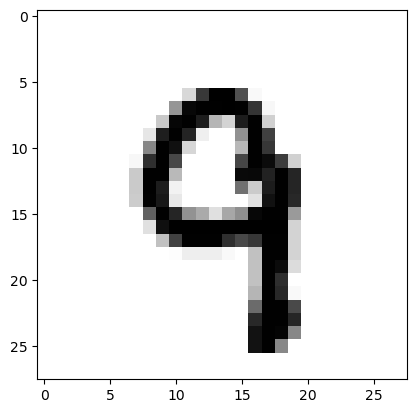

In [26]:
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')
plt.show()

And here are few more examples:

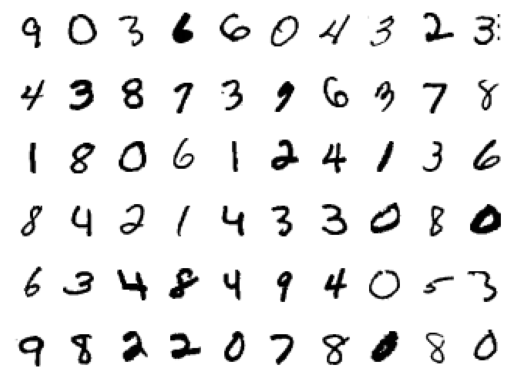

In [30]:
figure = plt.figure()
num_of_images = 60
for idx in range(1, num_of_images + 1):
    plt.subplot(6, 10, idx)
    plt.axis('off')
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray_r')

Before we start creating our models, I want to add a small function to calculate accuracy and loss:

In [32]:
def get_acc_loss(model, loader):
    correct=0
    total=0
    for images, labels in loader:
        images = images.reshape(-1, 28*28)
        output=model(images)
        pred = output.data.max(1, keepdim=True)[1]
        total+=labels.shape[0]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        loss=loss_func(output, labels)
    acc=100.*correct/total
    return acc, loss

Let's create our NN. This time I will use 2 hidden layers. I will also add `nn.Sequential` to avoid retyping our functions in the forward method. Lastly, I will use `flatten` to convert 28 by 28 array into a single dimension vector of size 28*28 = 784

In [35]:
input_size = 784     # 28*28
hidden_sizes = [128, 64] #two hidden layers
output_size = 10


class DigitMLP(nn.Module):
    
    def __init__(self):
        super(DigitMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



In [41]:
model = DigitMLP()
print(model)

n_epochs=5
lr=0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum =0.9)


DigitMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [42]:
train_loss = []
test_loss = []

train_acc=[]
test_acc=[]

In [43]:
n=len(trainloader)

for epoch in range(n_epochs):
    model.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        images = images.reshape(-1, 28*28)
        output = model(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()

        if (idx+1)%100==0:
            print(f'Epoch {epoch+1}/{n_epochs}, step {idx+1}/{n}, Loss={loss.item():.3}')

    model.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model, testloader)            
        test_acc.append(acc)
        test_loss.append(loss)
        print(f'\nTest Accuracy = {acc}, Test Loss = {loss} \n')

        acc, loss = get_acc_loss(model, trainloader)            
        train_acc.append(acc)
        train_loss.append(loss)

Epoch 1/5, step 100/938, Loss=0.427
Epoch 1/5, step 200/938, Loss=0.27
Epoch 1/5, step 300/938, Loss=0.352
Epoch 1/5, step 400/938, Loss=0.344
Epoch 1/5, step 500/938, Loss=0.37
Epoch 1/5, step 600/938, Loss=0.271
Epoch 1/5, step 700/938, Loss=0.198
Epoch 1/5, step 800/938, Loss=0.314
Epoch 1/5, step 900/938, Loss=0.151

Test Accuracy = 94.22000122070312, Test Loss = 0.09999676793813705 

Epoch 2/5, step 100/938, Loss=0.181
Epoch 2/5, step 200/938, Loss=0.151
Epoch 2/5, step 300/938, Loss=0.377
Epoch 2/5, step 400/938, Loss=0.189
Epoch 2/5, step 500/938, Loss=0.37
Epoch 2/5, step 600/938, Loss=0.108
Epoch 2/5, step 700/938, Loss=0.228
Epoch 2/5, step 800/938, Loss=0.104
Epoch 2/5, step 900/938, Loss=0.284

Test Accuracy = 95.62999725341797, Test Loss = 0.07111363112926483 

Epoch 3/5, step 100/938, Loss=0.0862
Epoch 3/5, step 200/938, Loss=0.06
Epoch 3/5, step 300/938, Loss=0.142
Epoch 3/5, step 400/938, Loss=0.0721
Epoch 3/5, step 500/938, Loss=0.247
Epoch 3/5, step 600/938, Loss=0.20

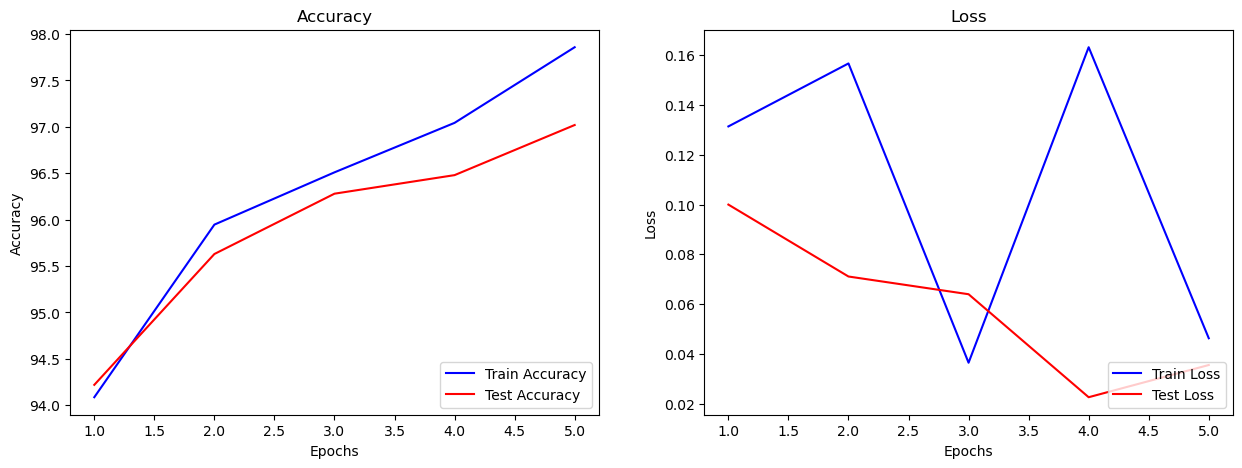

In [44]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc, color='red')
ax[0].legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy')

ax[1].plot(np.arange(1,n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss, color='red')
ax[1].legend(['Train Loss', 'Test Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')

plt.show()

In [47]:
predictions = []
y_true = []

# iterate over test data
for inputs, labels in testloader:

        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1])
        predictions.extend(output) # Save Prediction
        
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth


print('Confusion Matrix = \n',confusion_matrix(y_true, predictions))

Confusion Matrix = 
 [[ 963    0    2    1    1    1    5    1    3    3]
 [   0 1127    4    0    0    2    1    0    1    0]
 [   8    0 1000    4    5    0    4    9    2    0]
 [   0    0    5  970    0   23    0    8    3    1]
 [   0    0    2    0  942    0    5    4    1   28]
 [   4    0    0    3    1  874    4    1    3    2]
 [   5    3    1    0    6    5  937    0    1    0]
 [   1    6    7    6    0    0    0 1001    0    7]
 [   7    1    3   14    3   11    6    6  921    2]
 [   3    5    0    9    9    4    1    8    3  967]]


### How do we choose amount of layers and amount of nodes in each layer?

For input and output layer the this is easy, there is only one choice. However for hidden layers this is not an easy question and highly depends on many factors. Clearly, the more layers and more nodes we have the more computationally expensive model will be. Another thing to keep in mind is that the more layers we have, more likely we will get Vanishing Gradient Problem. So, for very deep networks, we should apply more spcialized algorithms. However, for most problems we don't need very deep networks:

1. If your data is linearly separable, then you actually dont need any hidden layers. You dont really need NN at all here.
2. A single hidden layer can solve most problems.
3. Problems that require two hidden layers are more rare, but we can create almost any desision boundary with it.
4. Generally, the more features you have, the more layers you will probably want. Hidden layers in deep NN are generally more complex than just a linear layers we discussed so far. Problems that often use deep NN:
   
       a. Image or video recognision problems will use deeper NN (CNN);
   
       b. Language processing (translation, text generation, etc) will use deep NN (RNN, Transformers)
   
       c. Time series forecasting often use deep NN (LSTM)
   
       d. Speech Recognition use deep CNN and/or RNN.
   
5. Adding more layers may lead to overfit, so more is not always better.

How about number of nodes in each hidden layer? Again there is no single answers to this, but here are common suggestions (keep in mind that these are not hard rules and there are many exceptions):

1. Number of nodes in the hidden layer should be between number of nodes in the input layer and the output layer.
2. Number of nodes in the hidden layer should be 2/3 of the sum of number of nodes in the input layer and the output layer.
3. Number of nodes in the hidden layer should be less than double the number of nodes in the input layer.
   
Other things that we can manipulate to improve our NN model:

1. Learning rate
2. Momentum (when we do SGD and you gradinet is small, the convergence slows down dramatically. Momentum let's you use previous gradients. It speeds up the convergence.
3. We can apply early stopping to avoid overfiting and improve performance
4. We can use other optimizers besides SGD ( such as Adam, Adagrad, AdaDelta, Nadam, Adamax, etc)

We will talk about momentum and optimizers in the future.

In [49]:
torch.save(model.state_dict(), '.\DigitMLPExample.pth')

Let's draw a picture and see if our model can guess the digit (The digit should be white on black background, and saved as Digit.png).

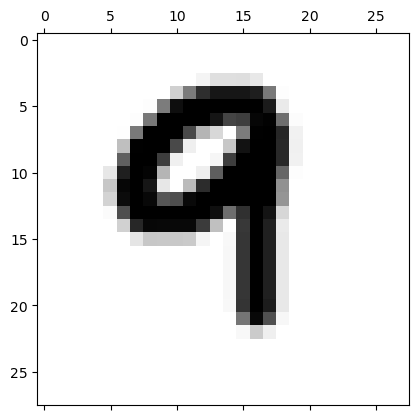

In [243]:
image = Image.open('Digit.png')
img = image.convert('L')    # converts it to greyscale
img = img.resize((28,28))
img = np.asarray(img)

plt.matshow(img, cmap = 'gray_r')
plt.show()

In [51]:
imgtensor = transform(np.array(img))
with torch.inference_mode():
    
    output = model(imgtensor)
    guess=(torch.max(torch.exp(output), 1)[1])[0]
    perc=torch.max(torch.exp(output)/torch.exp(output).sum())*100
    print(f'This is {guess}, and I am {perc:.1f}% confident about this')

This is 9, and I am 62.0% confident about this


Overall our guesses were good, but for image recognition, we should be using a different type of Neural Network called Convolutional Neural Network (CNN), which we will look at next time.

### Dealing with overfit

Neural networks are notorious at overfitting since they add a lot of complexity. This is even more prominent for small data sets. There are a few ways to combat overfitting:

1. For non-image data normalization is helpful
2. Data augmentation: adding small rotation, shifts and noise to images
3. Adding regularizatrion. Recall that weight decay in SGD is L2-regularization
4. Dropout: we can randomly drop a few neurons in each training iteration to add a bit of weight independence.
5. Early stopping. stop training when validation accuracy no longer improves.
6. Pooling: dimension reduction on images.

Let's take a smaller subset of digits and increase amount of epochs. We will also add extra nodes to hdden layer to force overfit. Then we will create a new model with few features to combat overfit. I will also use validation and test set.


In [307]:
# This function will split train set into train and validation and then create loaders for all three sets

def get_sets(train_data, test_data):
    valid_size = 0.2

    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=10,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=10,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=100,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

In [308]:
trainset_list= list(trainset)
testset_list= list(testset)
trainset_list=trainset_list[:20]
testset_list=testset_list[:2000]

trainloader, testloader, validloader=get_sets(trainset_list, testset_list)

In [309]:
input_size = 784     # 28*28
hidden_sizes = [512, 512] #two hidden layers
output_size = 10


class DigitMLP(nn.Module):
    
    def __init__(self):
        super(DigitMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



In [334]:
model1 = DigitMLP()
n_epochs=100
lr=0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=lr, momentum =0.9)

In [335]:
train_loss = []
val_loss = []
train_acc=[]
val_acc=[]

In [336]:
for epoch in range(n_epochs):
    model1.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model1(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()

    
    model1.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model1, validloader)            
        val_acc.append(acc)
        val_loss.append(loss)

        acc, loss = get_acc_loss(model1, trainloader)            
        train_acc.append(acc)
        train_loss.append(loss)
        
    if epoch%10==9:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss={loss.item():.3}')


Epoch 10/100, Loss=1.4
Epoch 20/100, Loss=0.0536
Epoch 30/100, Loss=0.00965
Epoch 40/100, Loss=0.00405
Epoch 50/100, Loss=0.00384
Epoch 60/100, Loss=0.00303
Epoch 70/100, Loss=0.00213
Epoch 80/100, Loss=0.00112
Epoch 90/100, Loss=0.0016
Epoch 100/100, Loss=0.00145


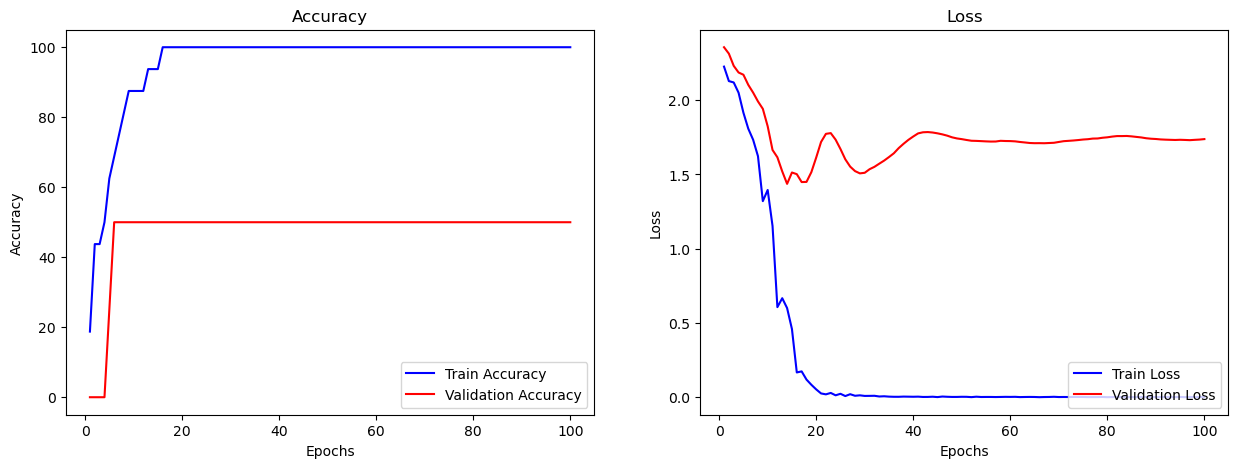

In [337]:


fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,n_epochs+1, 1), val_acc, color='red')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy')

ax[1].plot(np.arange(1,n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,n_epochs+1, 1), val_loss, color='red')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')

plt.show()

In [314]:
model1.eval()
with torch.inference_mode():
    acc, _ = get_acc_loss(model1, testloader)
    print(f'Accuracy on test set: {acc}')

Accuracy on test set: 41.349998474121094


As you can see we our model does perfectly on train set, but badly on test set. We are overfitting. Let add few things to our model. First thing we will add a bit of rotation to our images. Normally you can add those to your initial transform, but this time I will add it separately. Here is an example:

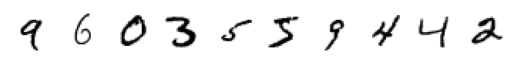

In [299]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 10
for index in range(0, num_of_images):
    plt.subplot(1, 10, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

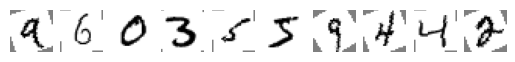

In [300]:
images=[transforms.RandomRotation(degrees=(0, 35))(im) for im in images]
figure = plt.figure()
num_of_images = 10
for index in range(0, num_of_images):
    plt.subplot(1, 10, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Next, we will use L2-Normalization by setting weight decay to 0.01. Finally, we will add a dropout layers to remove certain neurons. Note that dropout layer is not being used during testing. Your model will know if you are testing or training when you use `model.eval()` and `model.train()`.

In [321]:
input_size = 784     # 28*28
hidden_sizes = [512, 512] #two hidden layers
output_size = 10


class DigitMLP2(nn.Module):
    
    def __init__(self):
        super(DigitMLP2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(input_size,hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_sizes[1], output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [322]:
model2 = DigitMLP2()
n_epochs=100
lr=0.01

In [323]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=lr, momentum =0.9, weight_decay=0.01)

I will also create Early Stopping that will test validation set's loss. If it stops improving, we will stop training.

In [324]:
class EarlyStopping: 
    def __init__(self, patience=5, verbose=False, delta=0): 
        """ 
        Args: 
            patience (int): How long to wait after last time validation loss improved. 
            verbose (bool): If True, prints a message for each validation loss improvement. 
            delta (float): Minimum change to qualify as an improvement. 
        """ 
        self.patience = patience 
        self.verbose = verbose 
        self.delta = delta 
        self.counter = 0 
        self.best_score = np.inf  # Assuming we are minimizing the validation loss 
        self.early_stop = False 
 
    def __call__(self, val_loss): 
        score = val_loss 
 
        if score < self.best_score + self.delta: 
            self.best_score = score 
            self.counter = 0 
            if self.verbose: 
                print(f'Validation loss improved: {self.best_score:.6f}') 
        else: 
            self.counter += 1 
            if self.verbose: 
                print(f'Validation loss did not improve: {score:.6f}. Counter: {self.counter}/{self.patience}') 
            if self.counter >= self.patience: 
                self.early_stop = True 

In [325]:
early_stopping = EarlyStopping(patience=8, verbose=True) 

train_loss = []
val_loss = []
train_acc=[]
val_acc=[]



for epoch in range(n_epochs): 
    model2.train() 
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad() 
        images=transforms.RandomRotation((-25,25))(images)
        output = model2(images) 
        loss=loss_func(output, labels)
        loss.backward() 
        optimizer.step() 
 
    # Validation phase 
    model2.eval() 
    with torch.inference_mode(): 
            
        v_acc, v_loss = get_acc_loss(model2, valid_loader)            
        val_acc.append(v_acc)
        val_loss.append(v_loss)

        t_acc, t_loss = get_acc_loss(model2, train_loader)            
        train_acc.append(t_acc)
        train_loss.append(t_loss)
     
 
    print(f'Epoch {epoch+1}/{n_epochs}, Validation Loss: {v_loss:.6f}') 
 
    # Check early stopping 
    early_stopping(v_loss) 
 
    if early_stopping.early_stop: 
        print("Early stopping triggered")
        total_n_epochs=epoch+1
        break 

Epoch 1/100, Validation Loss: 2.248787
Validation loss improved: 2.248787
Epoch 2/100, Validation Loss: 2.259226
Validation loss did not improve: 2.259226. Counter: 1/8
Epoch 3/100, Validation Loss: 2.270352
Validation loss did not improve: 2.270352. Counter: 2/8
Epoch 4/100, Validation Loss: 2.276515
Validation loss did not improve: 2.276515. Counter: 3/8
Epoch 5/100, Validation Loss: 2.208485
Validation loss improved: 2.208485
Epoch 6/100, Validation Loss: 2.303345
Validation loss did not improve: 2.303345. Counter: 1/8
Epoch 7/100, Validation Loss: 2.028969
Validation loss improved: 2.028969
Epoch 8/100, Validation Loss: 2.043231
Validation loss did not improve: 2.043231. Counter: 1/8
Epoch 9/100, Validation Loss: 2.133953
Validation loss did not improve: 2.133953. Counter: 2/8
Epoch 10/100, Validation Loss: 2.098817
Validation loss did not improve: 2.098817. Counter: 3/8
Epoch 11/100, Validation Loss: 1.935215
Validation loss improved: 1.935215
Epoch 12/100, Validation Loss: 1.9858

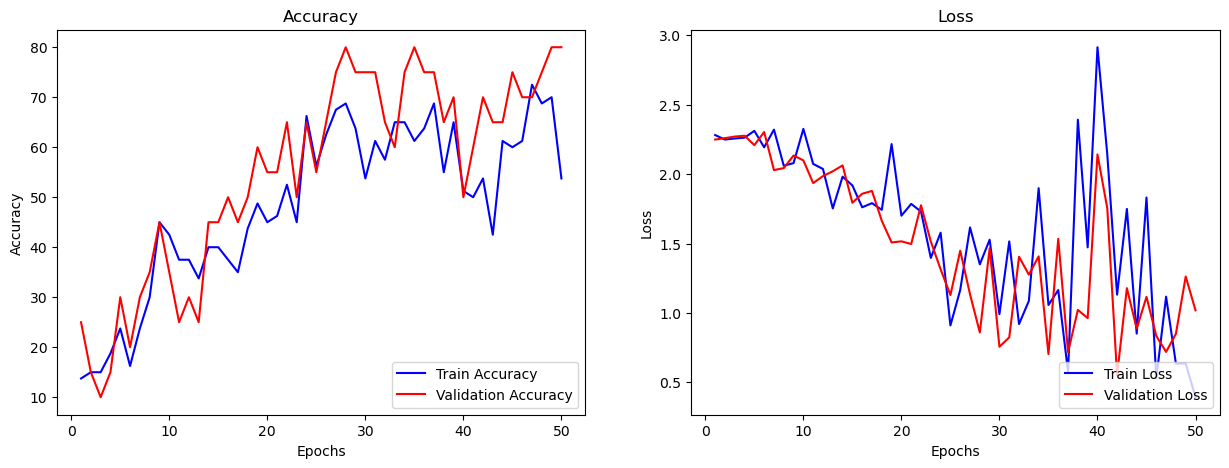

In [326]:
fig, ax= plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,total_n_epochs+1, 1), train_acc, color='blue')
ax[0].plot(np.arange(1,total_n_epochs+1, 1), val_acc, color='red')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy')

ax[1].plot(np.arange(1,total_n_epochs+1, 1), train_loss, color='blue')
ax[1].plot(np.arange(1,total_n_epochs+1, 1), val_loss, color='red')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')

plt.show()

In [327]:
model2.eval()
with torch.inference_mode():
    acc, _ = get_acc_loss(model2, testloader)
    print(f'Accuracy on test set: {acc}')

Accuracy on test set: 41.150001525878906
